In [1]:
import numpy as np
import pandas as pd
import pylab as pl
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.svm
import sklearn.learning_curve
import sklearn.neighbors
import gc

pl.rcParams['figure.figsize'] = (15, 4)

### 0. Data aquisition

Get the training data from 'Walmart Recruiting: Trip Type Classification' competition:
https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data

Note 1: you can also pass this assignment if you will provide notebook with 0.55 log loss or better result on 10-fold cross-validation. 

Note 2: if this competition is your project, consider this assignment as first steps in it. 



In [2]:
column_dtypes = {'ScanCount': 'int8'}
train = pd.read_csv('train.csv', low_memory=False, dtype=column_dtypes)
test = pd.read_csv('test.csv', low_memory=False, dtype=column_dtypes)

In [6]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017


In [7]:
test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002
1,1,Friday,1707710732,1,DAIRY,1526
2,1,Friday,89470001026,1,DAIRY,1431
3,1,Friday,88491211470,1,GROCERY DRY GOODS,3555
4,2,Friday,2840015224,1,DSD GROCERY,4408


### 1. Preliminary analysis

Give summary of train features. 

— Which of them are numerical and categorical? 

— What distributions do they have? Are distributions identical on test and train? 

— What features contain missing values? What's your guess why?

Note: Pandas library can be very handy.

In [3]:
data = train.append(test, ignore_index=True)
data['test'] = data.TripType.isnull()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300700 entries, 0 to 1300699
Data columns (total 8 columns):
DepartmentDescription    1298011 non-null object
FinelineNumber           1292585 non-null float64
ScanCount                1300700 non-null int8
TripType                 647054 non-null float64
Upc                      1292585 non-null float64
VisitNumber              1300700 non-null int64
Weekday                  1300700 non-null object
test                     1300700 non-null bool
dtypes: bool(1), float64(3), int64(1), int8(1), object(2)
memory usage: 71.9+ MB


#### TripType - categorical feature, target variable. VisitNumber - numerical feature. Weekday - categorical feature. Upc - categorical feature. ScanCount - numerical feature (number of particular products purchased, we can treat it also like nominal feature with order). DepartmentDescription - categorical feature. FinelineNumber - categorical feature (the organizer of this competition says that this is a custom cluster labels of the products)

#### Distribution of VisitNumber in train is the same as in test

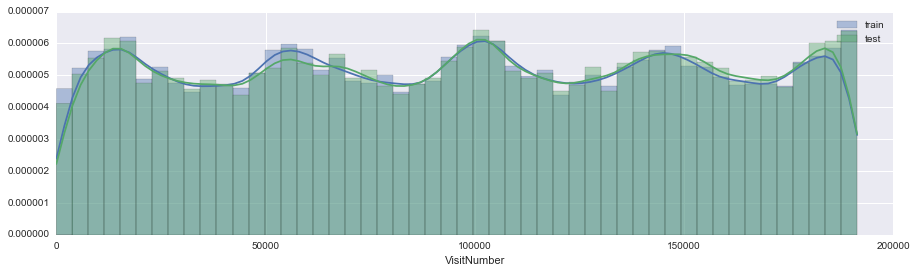

In [25]:
sns.distplot(train.VisitNumber, label='train')
sns.distplot(test.VisitNumber, label='test')
pl.legend()

#### Distribution of Weekday in train is the same as in test

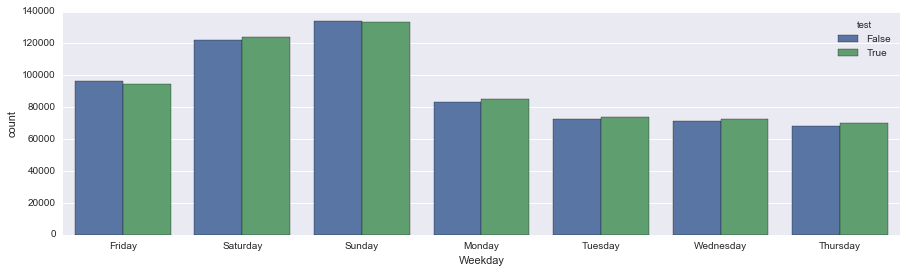

In [26]:
sns.countplot('Weekday', hue='test', data=data)

In [29]:
data.ix[data.Upc.isnull(), 'DepartmentDescription'].value_counts()

PHARMACY RX    5426
Name: DepartmentDescription, dtype: int64

#### There are missing values in Upc. This is the barcode symbology. Maybe, there wasn't Upc information about some product in a PHARMACY RX, or the data was potentially anonimyzed.

#### Distribution of Upc in train is the same as in test

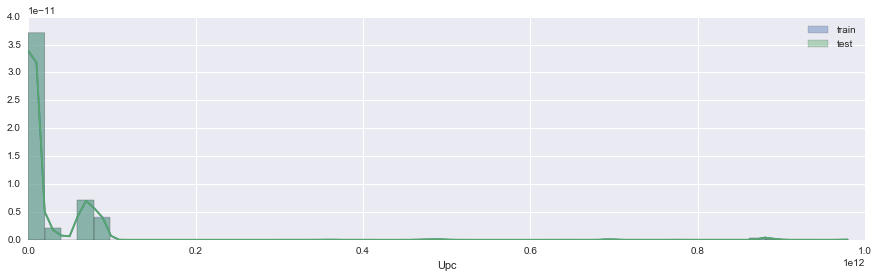

In [30]:
sns.distplot(train.Upc[train.Upc.notnull()], label='train')
sns.distplot(test.Upc[test.Upc.notnull()], label='test')
pl.legend()

#### Distribution of DepartmentDescription in train is the same as in test.

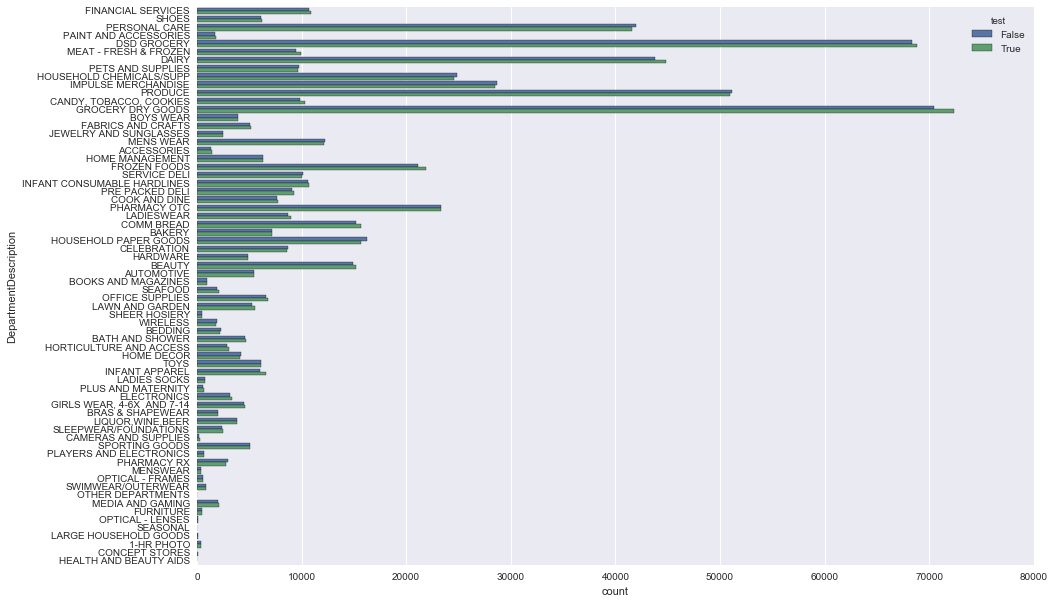

In [35]:
pl.figure(figsize=(15, 10))
sns.countplot(y='DepartmentDescription', hue='test', data=data, orient='v')

In [39]:
train.ix[train.FinelineNumber.isnull(), 'DepartmentDescription'].value_counts()

PHARMACY RX    2768
Name: DepartmentDescription, dtype: int64

#### Again, there is some problems with missing values in a PHARMACY RX department. The distributions of FinelineNumber in train and test are the same 

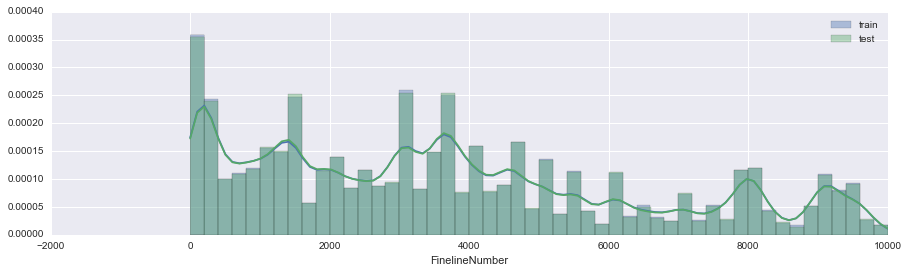

In [37]:
sns.distplot(train.FinelineNumber[train.FinelineNumber.notnull()], label='train')
sns.distplot(test.FinelineNumber[test.FinelineNumber.notnull()], label='test')
pl.legend()

#### The distributions of ScanCount in train and test look the same

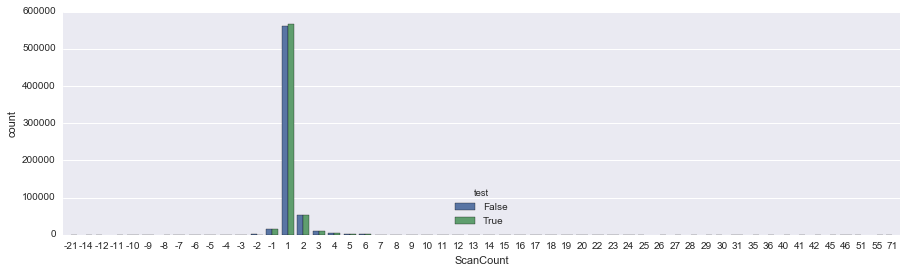

In [42]:
sns.countplot('ScanCount', hue='test', data=data)

### TripType distribution in the train (we're predicting this variable)

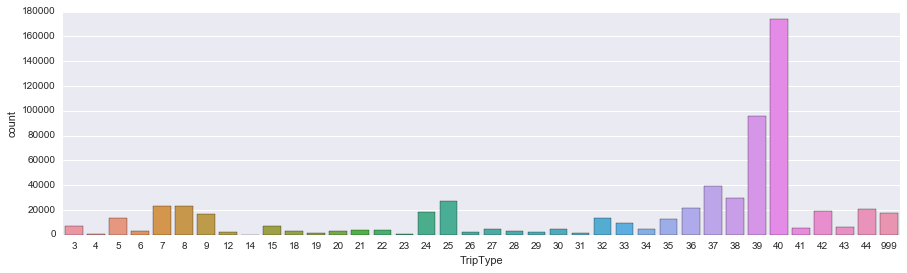

In [43]:
sns.countplot(train.TripType)

### 2. Data preprocessing and feature engineering

— Missing values. How do you choose to impute them? Why?

— String variables. Implement label and one-hot encoding. For what models it makes a difference? (Note: it may be better to use Pandas get_dummies method to one-hot encoder in sklearn).

— Combine observations by VisitNumber (Pandas groupby method can be very handy in that case). Make feature vector for each VisitNumber.  

— Split training data into even new_train and evaluation sets using train_test_split from sklearn. Fix random state for reproducibility of your results. 

— Choose cross-validation 5-fold split for your data (3-fold if your PC is not so fast). Do not forget to specify random state for your results reproducibility. 

#### Some algorithms don't support missing values (but, for example, trees can easily manipulate with them), therefore we need to impute them. For DepartmentDescription filling NA with string "Unknown Department" is good. We can fill NA in FinelineNumber and Upc with a number, that wasn't originally there (maybe, -1) and then use label encoder or one-hot encoding. Label encoder cannot provide enough information for linear models, because the number that we are assigning to a value does not make sense, but the model insists on numerical features, which have meaning of increased and decreased value. Label encoder for two many classes (for example, Upc) may be a problem even for logical models such as trees, for example, there is only a binary splits in CART algorithm and in order to get to some defined Upc number, we need very deep tree. One-hot encoding with additional label field is the good way to deal with categorical features (especially when there is an order)

#### Missing values of TripType represents test ones.

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300700 entries, 0 to 1300699
Data columns (total 8 columns):
DepartmentDescription    1298011 non-null object
FinelineNumber           1292585 non-null float64
ScanCount                1300700 non-null int8
TripType                 647054 non-null float64
Upc                      1292585 non-null float64
VisitNumber              1300700 non-null int64
Weekday                  1300700 non-null object
test                     1300700 non-null bool
dtypes: bool(1), float64(3), int64(1), int8(1), object(2)
memory usage: 71.9+ MB


In [4]:
data.DepartmentDescription.fillna('Unknown Department', inplace=True)
data.FinelineNumber.fillna(-1, inplace=True)
data.Upc.fillna(-1, inplace=True)

#### These two features contain two many categories for using one-hot encoder (we can use sparse matrices, but pandas returns NA values to store nonzero elements and there is no good support of scipy.sparse module by pandas yet). So, we'll encode Upc and FinelineNumber using LabelEncoder

In [6]:
data.Upc.nunique(), data.FinelineNumber.nunique()

(124694, 5354)

In [5]:
upc_encoder, fineline_encoder = sklearn.preprocessing.LabelEncoder(), sklearn.preprocessing.LabelEncoder()
data.Upc = upc_encoder.fit_transform(data.Upc)
data.FinelineNumber = fineline_encoder.fit_transform(data.FinelineNumber)

#### Using built-in pandas get_dummies

In [8]:
data.DepartmentDescription.nunique()

69

In [6]:
data = pd.get_dummies(data, columns=['DepartmentDescription', 'Weekday'])
data.head()

,FinelineNumber,ScanCount,TripType,Upc,VisitNumber,test,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,...,DepartmentDescription_TOYS,DepartmentDescription_Unknown Department,DepartmentDescription_WIRELESS,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,765,-1,999,81278,5,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,5022,1,30,71199,7,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2923,1,30,49823,7,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2384,2,26,11426,8,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,782,2,26,9797,8,False,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
d = {'FinelineNumber': {'FinelineNumber_min': 'min', 'FinelineNumber_max': 'max', 
                        'FinelineNumber_mean': 'mean', 'FinelineNumber_median': 'median'},
     'Upc': {'Upc_min': 'min', 'Upc_max': 'max','Upc_mean': 'mean', 'Upc_median': 'median'},
     'ScanCount': {'ScanCount_min': 'min', 'ScanCount_sum': 'sum', 'ScanCount_max': 'max', 'ScanCount_mean': 'mean'},
     'TripType': {'TripType': 'first'}, 
     'test': {'test': 'first'}}
d.update({x: {x: 'sum'} for x in data.columns if x.startswith('Department')})
data = data.groupby('VisitNumber').agg(d)

In [8]:
data.columns = data.columns.droplevel(0)
data.reset_index(inplace=True)
data.head()

,VisitNumber,DepartmentDescription_COMM BREAD,DepartmentDescription_LADIES SOCKS,DepartmentDescription_BEAUTY,DepartmentDescription_CELEBRATION,DepartmentDescription_HARDWARE,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_ELECTRONICS,DepartmentDescription_LADIESWEAR,DepartmentDescription_INFANT CONSUMABLE HARDLINES,...,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_SERVICE DELI,FinelineNumber_median,FinelineNumber_min,FinelineNumber_mean,FinelineNumber_max,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_FINANCIAL SERVICES
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1566,1081,1647.0,2375,0,1,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,3900,2879,3822.5,4611,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,2923,2923,2923.0,2923,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,3628,3628,3628.0,3628,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,765,765,765.0,765,0,0,0,1


### Normalizing using l2 norm (it is not required for tree models, but this way we'll have the same data for all models)

In [9]:
columns_to_normalize = [x for x in data.columns if x not in ['test', 'TripType']]
data.ix[:, columns_to_normalize] = sklearn.preprocessing.normalize(data[columns_to_normalize])

In [10]:
train = data[data.test == False]
del train['test'], data

In [11]:
target = train['TripType'].values
del train['TripType']

In [12]:
skf = sklearn.cross_validation.StratifiedKFold(target, n_folds=3, shuffle=True, random_state=25)
new_train, eval_train, new_targets, eval_targets = sklearn.cross_validation.train_test_split(
    train, target, test_size=0.2, random_state=25, stratify=target)

In [13]:
def plot_confusion_matrix(clf):
    pl.figure(figsize=(9, 9))
    clf.fit(new_train, new_targets)
    matrix = sklearn.metrics.confusion_matrix(eval_targets, clf.predict(eval_train)).astype('float')
    matrix /= matrix.sum(axis=1)[:, np.newaxis]
    pl.imshow(matrix, cmap='Reds', interpolation='nearest')
    pl.ylabel('True target')
    pl.xlabel('Predicted target')

### 3. KNN-classifier

— Try KNN classifier on the obtained features. Report accuracy and logarithmic loss (mean and std across the folds). How does this evaluation metrics change depending on neighbors number? Depending on distance metric? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

#### Trying KNN with default parameters (euclidean distance).  Euclidean distance on 84-dimentional data might not reflect required "difference" between customer's purchases

In [15]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
scores = -sklearn.cross_validation.cross_val_score(clf, train, target, scoring='log_loss', cv=skf)
print(scores)
print('Mean log-loss =', scores.mean(), 'Std =', scores.std())

[ 20.93911639  20.90674927  20.82243264]
('Mean log-loss =', 20.88943276950334, 'Std =', 0.049184483961442295)


#### Optimising number of nearest neighbors

In [27]:
param_name = 'n_neighbors'
param_range = [3, 25, 51, 101, 201, 301, 501]
clf = sklearn.neighbors.KNeighborsClassifier(n_jobs=-1)
train_scores, validation_scores = sklearn.learning_curve.validation_curve(
    clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

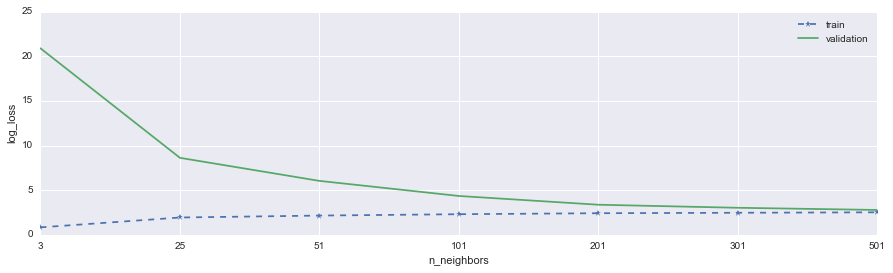

In [28]:
pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
pl.xlabel(param_name)
pl.xticks(np.arange(len(param_range)), param_range)
pl.ylabel('log_loss')
pl.legend()

In [29]:
print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())

('BEST LOG LOSS =', 2.7825980797603571)


### For the best number of nearest neighbors optimizing minkowski distance's parameter p

In [31]:
param_name = 'p'
param_range = [1, 2, 3, 5, 10]
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=501, n_jobs=-1)
train_scores, validation_scores = sklearn.learning_curve.validation_curve(
    clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

('BEST LOG LOSS =', 2.7293817115778545)


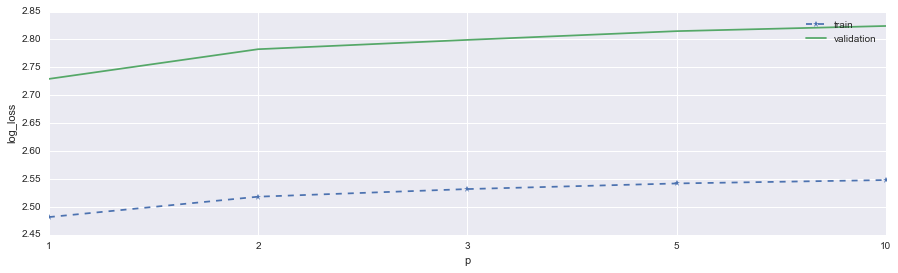

In [32]:
print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
pl.xlabel(param_name)
pl.xticks(np.arange(len(param_range)), param_range)
pl.ylabel('log_loss')
pl.legend()

#### We can tune classifier using GridSearch, but alternating optimization of parameters is not bad when we have several of them. In addition, we can see visually effects of overfitting or we can chose appropriate model for balance in complexity and quality

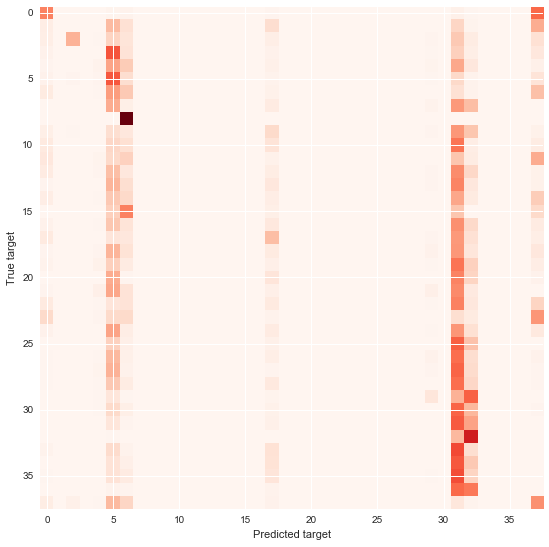

In [33]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=501, p=1, n_jobs=-1)
plot_confusion_matrix(clf)

### 4. Linear models 

— Try logistic regression and linear SVM on your features. Report accuracy and log loss. Compare it to KNN-classifier. How does performance differ whether you use data scaling or not? How does performance differ if you use on-hot or label encoded categorical features?

— Regularization. Play with l1 and l2 regularization parameters. Plot log loss score depending on different C values for l1 and l2 regularizations. What regualarization do you choose with which parameter? Why? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

In [35]:
clf = sklearn.linear_model.LogisticRegression(C=1, penalty='l2')
scores = -sklearn.cross_validation.cross_val_score(clf, train, target, scoring='log_loss', cv=skf)
print(scores)
print('Mean log-loss =', scores.mean(), 'Std =', scores.std())

[ 2.65884825  2.66252307  2.66477987]
('Mean log-loss =', 2.6620503956095871, 'Std =', 0.0024445295497174829)


In [38]:
param_name = 'C'
param_range = [0.1, 1, 5, 10, 20, 100]
clf = clf = sklearn.linear_model.LogisticRegression(C=1, penalty='l2')
train_scores, validation_scores = sklearn.learning_curve.validation_curve(
    clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

('BEST LOG LOSS =', 2.5830367398951095)


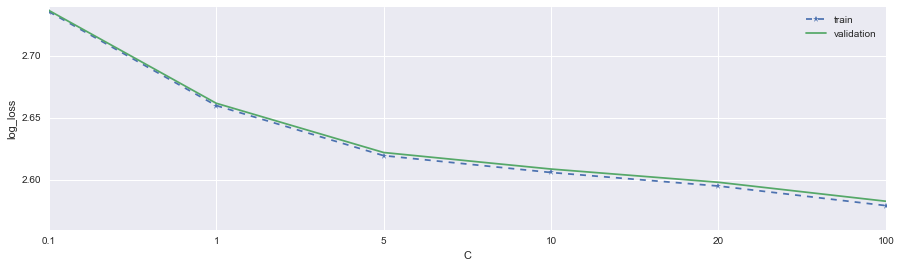

In [39]:
print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
pl.xlabel(param_name)
pl.xticks(np.arange(len(param_range)), param_range)
pl.ylabel('log_loss')
pl.legend()

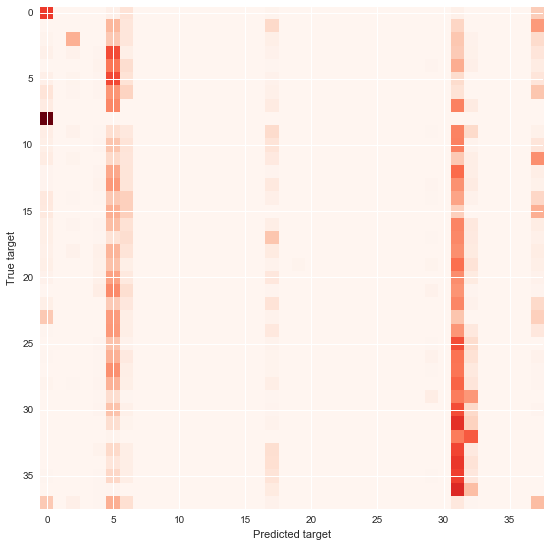

In [41]:
clf = sklearn.linear_model.LogisticRegression(C=20, penalty='l2')
plot_confusion_matrix(clf)

### 5. Tree-based models

### Random Forest

In [14]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20, max_depth=7, random_state=25, n_jobs=-1)
scores = -sklearn.cross_validation.cross_val_score(clf, train, target, scoring='log_loss', cv=skf)
print(scores)
print('Mean log-loss =', scores.mean(), 'Std =', scores.std())

[ 2.08544011  2.09729417  2.10703934]
Mean log-loss = 2.09659120607 Std = 0.008831847636


In [17]:
param_name = 'max_depth'
param_range = [5, 7, 9, 11, 20, 30, None]
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20, random_state=25)
train_scores, validation_scores = sklearn.learning_curve.validation_curve(
    clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

BEST LOG LOSS = 1.443769874


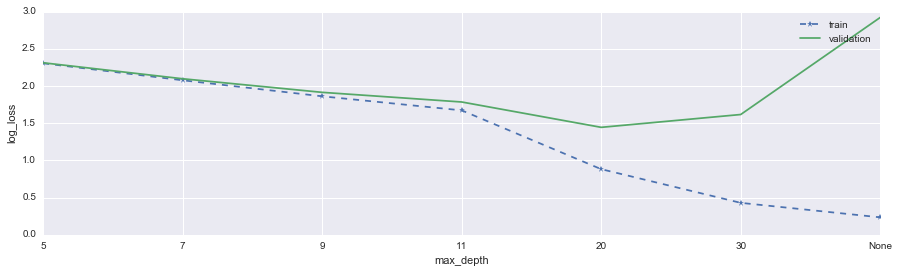

In [18]:
print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
pl.xlabel(param_name)
pl.xticks(np.arange(len(param_range)), param_range)
pl.ylabel('log_loss')
pl.legend()

In [19]:
param_name = 'n_estimators'
param_range = [20, 40, 60, 80]
clf = sklearn.ensemble.RandomForestClassifier(max_depth=20, random_state=25)
train_scores, validation_scores = sklearn.learning_curve.validation_curve(
    clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

BEST LOG LOSS = 1.36019675841


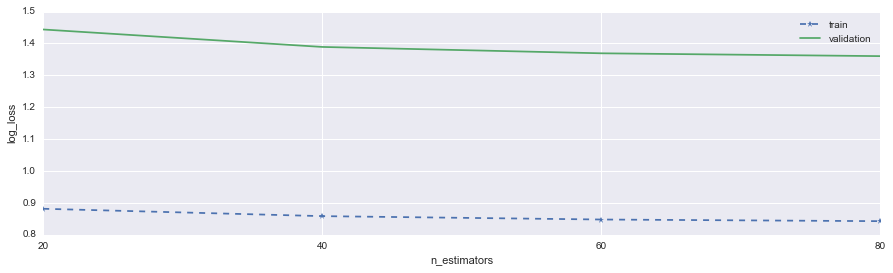

In [20]:
print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
pl.xlabel(param_name)
pl.xticks(np.arange(len(param_range)), param_range)
pl.ylabel('log_loss')
pl.legend()

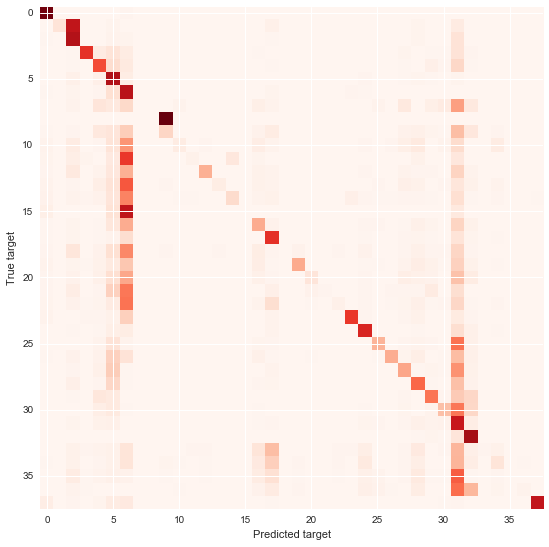

In [21]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=40, max_depth=20, random_state=25)
plot_confusion_matrix(clf)

### XGB

In [28]:
clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=50, seed=25, objective='multi:softprob')
scores = -sklearn.cross_validation.cross_val_score(clf, train, target, scoring='log_loss',  cv=skf)
print(scores)
print('Mean log-loss =', scores.mean(), 'Std =', scores.std())

/home/oem/anaconda3/lib/python3.5/site-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)
/home/oem/anaconda3/lib/python3.5/site-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


[ 2.48636847  2.49516443  2.4952015 ]
Mean log-loss = 2.49224479989 Std = 0.00415522061588


/home/oem/anaconda3/lib/python3.5/site-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


In [30]:
# param_name = 'max_depth'
# param_range = [1,2,3,4,5]
# clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=50, seed=25, objective='multi:softprob')
# train_scores, validation_scores = sklearn.learning_curve.validation_curve(
#     clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

In [31]:
# print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
# pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
# pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
# pl.xlabel(param_name)
# pl.xticks(np.arange(len(param_range)), param_range)
# pl.ylabel('log_loss')
# pl.legend()

In [25]:
# param_name = 'n_estimators'
# param_range = [20, 50, 100, 150, 200]
# clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, seed=25)
# train_scores, validation_scores = sklearn.learning_curve.validation_curve(
#     clf, train, target, param_name, param_range, cv=skf, scoring='log_loss')

In [26]:
# print('BEST LOG LOSS =', -validation_scores.mean(axis=1).max())
# pl.plot(np.arange(len(param_range)), -train_scores.mean(axis=1), '--*', label='train')
# pl.plot(np.arange(len(param_range)), -validation_scores.mean(axis=1), label='validation')
# pl.xlabel(param_name)
# pl.xticks(np.arange(len(param_range)), param_range)
# pl.ylabel('log_loss')
# pl.legend()

— Try vanilla Random Forest, AdaBoost, GBDT from sklearn and GBDT from xgboost. Report cross-validation log loss (mean and std) for each of these models.

— Random Forest. Find best parameters for the Random Forest using grid search on cross-validation. Which of them are the most important? Report result on evaluation test. 

— Adaboost. Find the best values of parameters for the AdaBoost using grid search on cross-validation. Which of them are the most important? Plot learning curve (log loss on each conscutive iteration) for the best AdaBoost on new_train and evaluation sets. Note: staged_predict_proba method can be very useful. 

— GBDT. Compare speed and performance of sklearn/xgboost GBDT implementation with similar parameters. Which implementation do your choose? Do not forget to utilise all of your CPUs/threads to speed up calculations. Find best parameters for the GBDT using grid search on cross-validation. What are the most important? Plot learning curve (log loss on each consecutive iteration) for the best GBDT on new_train and evaluation sets. Note: staged_predict_proba method can be very useful for sklearn and evals_result method for xgboost.


### 6. Model comaprison and combination

— Compare performance of all used models in terms of accuracy and log loss on evaluation. What is the best single model performance?

— (optional) Try to imporve your single model performnace with weighted combination of other models predictions. Note: sklearn VotingClassifier with 'softmax' option can be useful. What is the best model performance on evaluation?

### We can achieve balance between quality, speed of training and speed of tuning parameters using Random Forest. Confusion matrix shows that we can identify some trip types very weel but there are several trip types that we cannot identify.   